#**Import Libraries and Download Data**

In [14]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
import math
from warnings import simplefilter
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

# Mute sklearn warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Download stock price data
data = yf.download("BBCA.JK", start="2019-01-01", end="2023-01-01")

[*********************100%%**********************]  1 of 1 completed


In [15]:
data.head

<bound method NDFrame.head of               Open    High     Low   Close    Adj Close    Volume
Date                                                             
2019-01-01  5200.0  5200.0  5200.0  5200.0  4736.543457         0
2019-01-02  5200.0  5245.0  5200.0  5240.0  4772.978027  35956000
2019-01-03  5200.0  5220.0  5115.0  5180.0  4718.325195  72358000
2019-01-04  5175.0  5205.0  5125.0  5205.0  4741.098145  51465000
2019-01-07  5265.0  5325.0  5245.0  5245.0  4777.533203  73438000
...            ...     ...     ...     ...          ...       ...
2022-12-26  8500.0  8625.0  8500.0  8575.0  8367.039062  20495900
2022-12-27  8600.0  8650.0  8575.0  8600.0  8391.432617  27193800
2022-12-28  8650.0  8650.0  8550.0  8650.0  8440.219727  40420200
2022-12-29  8525.0  8600.0  8500.0  8575.0  8367.039062  47020900
2022-12-30  8575.0  8650.0  8550.0  8550.0  8342.645508  44681400

[993 rows x 6 columns]>

In [16]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [17]:
print(data.shape)

(993, 6)


In [18]:
data.iloc[:, 2:-1].describe()

,Low,Close,Adj Close
count,993.000000,993.000000,993.000000
mean,6582.588117,6647.280967,6279.107723
std,969.665488,976.159468,1040.762161
min,4325.000000,4430.000000,4084.944336
25%,5890.000000,5970.000000,5510.605957
50%,6360.000000,6420.000000,6067.953613
75%,7325.000000,7375.000000,7107.901855
max,9000.000000,9300.000000,9039.166016


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 993 entries, 2019-01-01 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       993 non-null    float64
 1   High       993 non-null    float64
 2   Low        993 non-null    float64
 3   Close      993 non-null    float64
 4   Adj Close  993 non-null    float64
 5   Volume     993 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 54.3 KB


In [21]:
#Normalisasi Data : Min-Max Scaler

close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [22]:
# Extract original and scaled close prices
original_close_prices = data['Close'].values
scaled_close_prices = scaled_data.flatten()

# Calculate statistics
original_stats = pd.Series(original_close_prices).describe()
scaled_stats = pd.Series(scaled_close_prices).describe()

# Print the summary
print("Original Close Prices Statistics:")
print(original_stats)

print("\nScaled Close Prices Statistics:")
print(scaled_stats)


Original Close Prices Statistics:
count     993.000000
mean     6647.280967
std       976.159468
min      4430.000000
25%      5970.000000
50%      6420.000000
75%      7375.000000
max      9300.000000
dtype: float64

Scaled Close Prices Statistics:
count    993.000000
mean       0.455294
std        0.200443
min        0.000000
25%        0.316222
50%        0.408624
75%        0.604723
max        1.000000
dtype: float64


In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot all prices
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index, y=data['Open'], mode='lines', name='Opening Price', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low Price', line=dict(color='black')))
fig.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price', line=dict(color='blue')))

fig.update_layout(
    title='Stock Price History',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

# Plot subplots for each individual price
fig_subplots = make_subplots(rows=2, cols=2, subplot_titles=('Opening Price', 'Closing Price', 'Low Price', 'High Price'))

fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Open'], mode='lines', name='Opening Price', line=dict(color='red')), row=1, col=1)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price', line=dict(color='green')), row=1, col=2)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Low Price', line=dict(color='black')), row=2, col=1)
fig_subplots.add_trace(go.Scatter(x=data.index, y=data['High'], mode='lines', name='High Price', line=dict(color='blue')), row=2, col=2)

fig_subplots.update_layout(title='Stock Price Subplots', showlegend=False)

fig.show()
fig_subplots.show()

#**Data Preprocessing and Preparation**

In [25]:
# Data preparation
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + n_steps, 0]]]))
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 120
X, y = prepare_data(scaled_data, n_steps)

# Splitting into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


#**Hyperparameter Tuning**

In [26]:
# Define hyperparameter search space
space = {
    'units': hp.choice('units', [50, 100, 150]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning rate', np.log(0.001), np.log(0.01)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


#**Model Building and Training**

In [ ]:
# Create a function to build and train the model with hyperparameters
from tensorflow.keras.optimizers import Adamax

def objective(params, model_type, X_train, y_train, X_test, y_test):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_orig, y_pred)
    return mse, history

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for LSTM and GRU
best_lstm = fmin(fn=lambda params: objective(params, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test)[0],
                 space=space, algo=tpe.suggest, max_evals=20, trials=trials_lstm)

best_gru = fmin(fn=lambda params: objective(params, 'gru', X_train_gru, y_train, X_test_gru, y_test)[0],
                space=space, algo=tpe.suggest, max_evals=20, trials=trials_gru)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)
best_params_gru = space_eval(space, best_gru)


6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 15ms/step

6/6 [==============================] - 2s 36ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 2s 14ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 9ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 2s 14ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 16ms/step

6/6 [==============================] - 1s 8ms/step

6/6 [==============================] - 1s 13ms/step



#**Final Model and History Plot**

In [ ]:
# Build the final LSTM model using the best hyperparameters
final_model_lstm = Sequential([
    LSTM(units=best_params_lstm['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units'], return_sequences=True),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units']),
    Dense(units=1)
])

final_model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

# Train the final LSTM model
history_lstm = final_model_lstm.fit(X_train_lstm, y_train, epochs=best_params_lstm['epochs'],
                                    batch_size=best_params_lstm['batch_size'], verbose=2,
                                    validation_split=0.1, callbacks=[early_stopping])

# Build the final GRU model using the best hyperparameters
final_model_gru = Sequential([
    GRU(units=best_params_gru['units'], return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units'], return_sequences=True),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units']),
    Dense(units=1)
])

final_model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

# Train the final GRU model
history_gru = final_model_gru.fit(X_train_gru, y_train, epochs=best_params_gru['epochs'],
                                  batch_size=best_params_gru['batch_size'], verbose=2,
                                  validation_data=(X_test_gru, y_test), callbacks=[early_stopping])


Epoch 1/150
20/20 - 6s - loss: 0.0357 - val_loss: 0.0354 - 6s/epoch - 324ms/step
Epoch 2/150
20/20 - 0s - loss: 0.0055 - val_loss: 0.0090 - 316ms/epoch - 16ms/step
Epoch 3/150
20/20 - 0s - loss: 0.0033 - val_loss: 9.3943e-04 - 314ms/epoch - 16ms/step
Epoch 4/150
20/20 - 0s - loss: 0.0028 - val_loss: 0.0023 - 322ms/epoch - 16ms/step
Epoch 5/150
20/20 - 0s - loss: 0.0025 - val_loss: 0.0038 - 306ms/epoch - 15ms/step
Epoch 6/150
20/20 - 0s - loss: 0.0024 - val_loss: 0.0014 - 314ms/epoch - 16ms/step
Epoch 7/150
20/20 - 0s - loss: 0.0023 - val_loss: 7.5130e-04 - 320ms/epoch - 16ms/step
Epoch 8/150
20/20 - 0s - loss: 0.0025 - val_loss: 0.0054 - 320ms/epoch - 16ms/step
Epoch 9/150
20/20 - 0s - loss: 0.0022 - val_loss: 0.0014 - 310ms/epoch - 15ms/step
Epoch 10/150
20/20 - 0s - loss: 0.0021 - val_loss: 0.0017 - 313ms/epoch - 16ms/step
Epoch 11/150
20/20 - 0s - loss: 0.0018 - val_loss: 0.0014 - 322ms/epoch - 16ms/step
Epoch 12/150
20/20 - 0s - loss: 0.0018 - val_loss: 7.4132e-04 - 316ms/epoch - 1

#**Evaluasi Model dan Visualisasi**

6/6 [==============================] - 1s 11ms/step
Performance Metrics for LSTM:
Mean Squared Error (MSE): 2311.1433071000206
Root Mean Squared Error (RMSE): 48.074351863545914
Mean Absolute Percentage Error (MAPE): 0.45231714697347236
6/6 [==============================] - 1s 9ms/step
Performance Metrics for GRU:
Mean Squared Error (MSE): 2131.1617907360596
Root Mean Squared Error (RMSE): 46.164507911772
Mean Absolute Percentage Error (MAPE): 0.4413840232921354


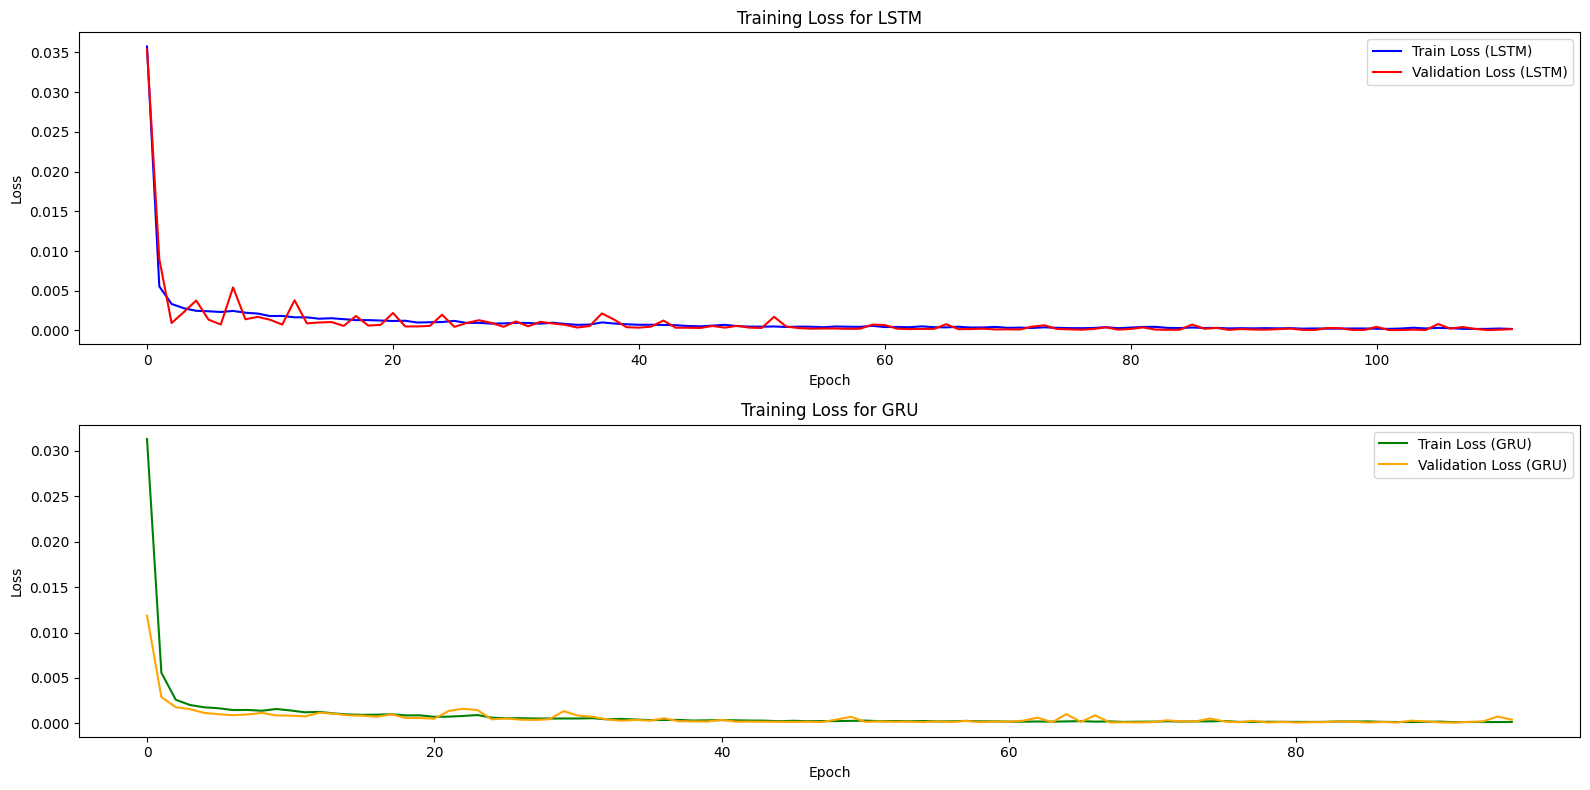

In [ ]:
# Model evaluation for LSTM
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_orig_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_orig_lstm, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test_orig_lstm - y_pred_lstm) / y_test_orig_lstm)) * 100

# Display results for LSTM
print("Performance Metrics for LSTM:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

# Model evaluation for GRU
y_pred_gru = final_model_gru.predict(X_test_gru)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_orig_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for GRU
mse_gru = mean_squared_error(y_test_orig_gru, y_pred_gru)
rmse_gru = math.sqrt(mse_gru)
mape_gru = np.mean(np.abs((y_test_orig_gru - y_pred_gru) / y_test_orig_gru)) * 100

# Display results for GRU
print("Performance Metrics for GRU:")
print("Mean Squared Error (MSE):", mse_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("Mean Absolute Percentage Error (MAPE):", mape_gru)

# Visualize predictions for the final LSTM model
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_test_orig_lstm.flatten(),
                         mode='lines',
                         name="Actual Stock Prices",
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_pred_lstm.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (LSTM)",
                         line=dict(color='red')))

# Visualize predictions for the final GRU model
fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                         y=y_pred_gru.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (GRU)",
                         line=dict(color='orange')))

fig.update_layout(title="Stock Price Prediction (LSTM vs GRU)",
                  xaxis_title="Date",
                  yaxis_title="Stock Price (IDR)",
                  template='plotly_dark')

fig.show()

# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import mean_squared_error
import math
from hyperopt import fmin, tpe, hp, space_eval, Trials
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Streamlit app
def main():
    st.title("Stock Price Prediction App")

    # Download stock price data
    st.sidebar.header("Data Download")
    stock_symbol = st.sidebar.text_input("Enter Stock Symbol (e.g., BBCA.JK):", "BBCA.JK")
    start_date = st.sidebar.date_input("Start Date", pd.to_datetime("2019-01-01"))
    end_date = st.sidebar.date_input("End Date", pd.to_datetime("2023-01-01"))

    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Data preprocessing
    close_prices = data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    # Data preparation
    n_steps = st.sidebar.slider("Select Number of Time Steps:", min_value=10, max_value=300, value=120, step=10)
    X, y = prepare_data(scaled_data, n_steps)

    # Splitting into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape data for LSTM and GRU models
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Sidebar for hyperparameter tuning
    st.sidebar.header("Hyperparameter Tuning")
    units = st.sidebar.selectbox("Select Number of Units:", [50, 100, 150], index=1)
    dropout_rate = st.sidebar.slider("Select Dropout Rate:", min_value=0.2, max_value=0.5, value=0.4, step=0.01)
    learning_rate = st.sidebar.slider("Select Learning Rate:", np.log(0.001), np.log(0.01), value=np.log(0.005), step=0.001)
    epochs = st.sidebar.selectbox("Select Number of Epochs:", [50, 100, 150], index=1)
    batch_size = st.sidebar.selectbox("Select Batch Size:", [32, 64, 128], index=1)

    # Hyperparameter search space
    space = {
        'units': units,
        'dropout_rate': dropout_rate,
        'learning_rate': np.exp(learning_rate),
        'epochs': epochs,
        'batch_size': batch_size
    }

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Run hyperparameter optimization
    best_params_lstm, history_lstm, y_pred_lstm, y_test_orig_lstm = run_optimization(space, 'lstm', X_train_lstm, y_train, X_test_lstm, y_test, scaler, early_stopping)
    best_params_gru, history_gru, y_pred_gru, y_test_orig_gru = run_optimization(space, 'gru', X_train_gru, y_train, X_test_gru, y_test, scaler, early_stopping)

    # Display results
    st.header("Results for LSTM Model")
    display_results(best_params_lstm, history_lstm, y_test_orig_lstm, y_pred_lstm)

    st.header("Results for GRU Model")
    display_results(best_params_gru, history_gru, y_test_orig_gru, y_pred_gru)

    # Visualize predictions for the final LSTM model
    st.header("Visualize Predictions (LSTM)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_lstm, y_pred_lstm)

    # Visualize predictions for the final GRU model
    st.header("Visualize Predictions (GRU)")
    visualize_predictions(data, train_size, n_steps, y_test_orig_gru, y_pred_gru)

    # Plot training history using Matplotlib
    st.header("Training History")
    plot_training_history(history_lstm, history_gru)


def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        lag_values = data[i:(i + n_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + n_steps, 0]]]))
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)


def run_optimization(space, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Set up the Trials object to keep track of the optimization process
    trials = Trials()

    # Use the fmin function for Bayesian optimization
    best_params = fmin(fn=lambda params: objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping),
                      space=space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Get the best hyperparameters from the optimization results
    best_params = space_eval(space, best_params)

    # Build the final model using the best hyperparameters
    final_model = build_model(best_params, model_type, X_train)

    # Train the final model
    history = final_model.fit(X_train, y_train,
                              epochs=best_params['epochs'],
                              batch_size=best_params['batch_size'],
                              verbose=2,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    return best_params, history, y_pred, y_test_orig


def build_model(params, model_type, X_train):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))
    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')
    return model


def objective(params, model_type, X_train, y_train, X_test, y_test, scaler, early_stopping):
    # Build and train the model
    final_model = build_model(params, model_type, X_train)
    history = final_model.fit(X_train, y_train,
                              epochs=params['epochs'],
                              batch_size=params['batch_size'],
                              verbose=0,
                              validation_split=0.1,
                              callbacks=[early_stopping])

    # Model evaluation
    y_pred = final_model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and return mean squared error
    mse = mean_squared_error(y_test_orig, y_pred)
    return mse


def display_results(best_params, history, y_test_orig, y_pred):
    mse = mean_squared_error(y_test_orig, y_pred)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

    st.write("Best Hyperparameters:", best_params)
    st.write("Mean Squared Error (MSE):", mse)
    st.write("Root Mean Squared Error (RMSE):", rmse)
    st.write("Mean Absolute Percentage Error (MAPE):", mape)

    # Plot training loss
    st.line_chart(pd.DataFrame({'Train Loss': history.history['loss'], 'Validation Loss': history.history['val_loss']}))


def visualize_predictions(data, train_size, n_steps, y_test_orig, y_pred):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_test_orig.flatten(),
                             mode='lines',
                             name="Actual Stock Prices",
                             line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=data.index[train_size + n_steps:],
                             y=y_pred.flatten(),
                             mode='lines',
                             name="Predicted Stock Prices",
                             line=dict(color='red')))

    fig.update_layout(title="Stock Price Prediction",
                      xaxis_title="Date",
                      yaxis_title="Stock Price (IDR)",
                      template='plotly_dark')

    st.plotly_chart(fig)


def plot_training_history(history_lstm, history_gru):
    plt.figure(figsize=(16, 8))

    # Plot training loss for LSTM
    plt.subplot(2, 1, 1)
    plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
    plt.title('Training Loss for LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training loss for GRU
    plt.subplot(2, 1, 2)
    plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
    plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
    plt.title('Training Loss for GRU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    st.pyplot()

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed
6/6 [==============================] - 1s 16ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 17ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 17ms/step

6/6 [==============================] - 1s 20ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 21ms/step

6/6 [==============================] - 1s 13ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 16ms/step

6/6 [==============================] - 1s 18ms/step

6/6 [==============================] - 2s 18ms/step

6/6 [==============================] - 1s 15ms/step

6/6 [==============================] - 1s 14ms/step

6/6 [==============================] - 1s 17ms/step

6/6 [=========================

<Figure size 1600x800 with 0 Axes>

In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00


In [12]:
!wget -q -O - ipv4.icanhazip.com

35.230.50.77


In [13]:
! streamlit run app.py & npx localtunnel --port 8501

[##................] - fetchMetadata: sill resolveWithNewModule is-fullwidth-co


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.230.50.77:8501

npx: installed 22 in 6.191s
your url is: https://lucky-carpets-smell.loca.lt
2023-12-20 21:56:03.345818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 21:56:03.345989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 21:56:03.355403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 21:56:03.411570: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
from google.colab import files

# Save the final LSTM model
final_model_lstm.save("final_model_lstm.h5")

# Download the saved LSTM model
files.download("final_model_lstm.h5")

# Save the final GRU model
final_model_gru.save("final_model_gru.h5")

# Download the saved GRU model
files.download("final_model_gru.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>